In [3]:
import numpy as np
import os, cv2, torch, config
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
device = torch.device("cpu")


In [2]:
torch.cuda.is_available()

False

In [4]:
image_path1 = os.path.join(os.getcwd(), "images/sample.jpg")

img1 = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)[np.newaxis, :, :]  ## (1, H, W)
img1 = img1.astype(float) / img1.max()
img1 = torch.Tensor(img1)
img1 = img1.to(device)
img1.shape

torch.Size([1, 576, 720])

In [6]:
def display_patches(img_list): #receives a list of torch tensors as input
    fig = plt.figure()
    for i in range(len(img_list)):
        im = img_list[i]
        if type(im) == torch.Tensor:
            im = im.numpy()
        fig.add_subplot(1,len(img_list),i+1)
        plt.imshow(im)

    plt.show()
    return


def nmf_prep(activations):
    data = None
    assert len(activations) != 0
    if len(activations) == 1:
        print("Need at least two activation maps in list!")
        return
    print("Length of activation list: ", len(activations))
    b, c, h, w = activations[0].shape
    #loop initial condition, terminating condition, and invariant - always think of these
    #array[i] (op) array[i+1] usually results in a error due to the terminating condition at the end
    for i in range(len(activations)-1):
        if i == 0:
            data = torch.cat([activations[i].squeeze().reshape(h*w, c), activations[i+1].squeeze().reshape(h*w, c)], dim = 0)
        else:
            data = torch.cat([data, activations[i+1].squeeze().reshape(h*w, c)], dim = 0)

    return data

#data must be a torch tensor
def apply_nmf(data, k):
    nmf_input = None
    if type(data) == torch.Tensor:
        nmf_input = data.detach().numpy()
    nmf = NMF(n_components=k, max_iter=99)
    H = nmf.fit_transform(nmf_input)
    W = nmf.components_
    return H, W
        
def unpack_heatmaps(H, h, w): #input: H from HW of NMF
    n_h_w, k = H.shape
    num_imgs = n_h_w // (h*w)

    f = lambda x : x.reshape(h,w, k)
    heatmap_list = [f(H[i*h*w:(i+1)*h*w,:]) for i in range(num_imgs)]

    print(len(heatmap_list))
    return heatmap_list
    


In [12]:
num_patches = 3

patch_size = 128
img_patches = []
#maintain img patches as torch tensors
for i in range(num_patches):
    img_patches.append(img1[:,patch_size*i:patch_size*(i+1),patch_size*i:patch_size*(i+1)].squeeze())
    if i > 0:
        assert img_patches[i-1].shape == img_patches[i].shape

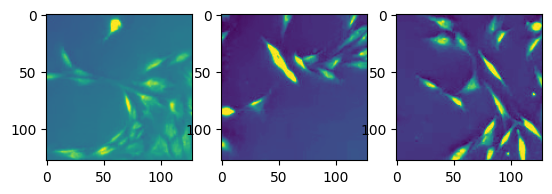

In [13]:
display_patches(img_patches)

In [7]:
import torchvision
from torchvision.models import vgg19, VGG19_Weights
vgg19_pretrained = vgg19(weights = VGG19_Weights.IMAGENET1K_V1)
print(vgg19_pretrained)

vgg_model = vgg19_pretrained.to(torch.device("cpu"))
vgg_model.eval()
vgg_model_parts = torch.nn.Sequential(*list(vgg_model.children())[:-1])
vgg_model_parts[0][0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg_model_parts = vgg_model_parts[0]

sample = vgg_model_parts(img1)
print(img1.shape)
print(sample.shape)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [22]:
def upsample_img(img, factor):

    m = torch.nn.UpsamplingBilinear2d(scale_factor=factor)
    return m(img)

def threshold(img):
    im = None
    if type(img) == torch.Tensor:
        im = img.squeeze().detach().numpy()
    threshold = np.percentile(im, 75)
    im = np.where(im > threshold, 255, 0)
    return im


In [9]:
sample = upsample_img(sample, 32)


In [10]:
sample.shape

torch.Size([512, 576, 704])

In [29]:
activation_list = []
for img in img_patches:
    im = threshold(upsample_img(vgg_model_parts(img.unsqueeze(0).unsqueeze(0)), 32))
    activation_list.append(torch.from_numpy(im).unsqueeze(0))

In [30]:
for act in activation_list:
    print(act.shape)
    print(type(act))


torch.Size([1, 512, 128, 128])
<class 'torch.Tensor'>
torch.Size([1, 512, 128, 128])
<class 'torch.Tensor'>
torch.Size([1, 512, 128, 128])
<class 'torch.Tensor'>


In [32]:
data = nmf_prep(activation_list)
H, W = apply_nmf(data, 1)
hm_list = unpack_heatmaps(H, 128, 128)


Length of activation list:  3
3


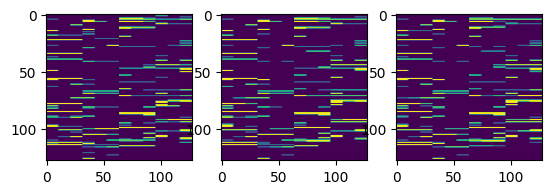

In [33]:
display_patches(hm_list)